## Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats



# Generating Data

/tmp/ipykernel_7699/1922308429.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.rand(1)
/tmp/ipykernel_7699/1922308429.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = w[1]*x[i] + b[1] + np.random.randn(1)*np.sqrt(v[1])
/tmp/ipykernel_7699/1922308429.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = w[0]*x[i] + b[0] + np.random.randn(1)*np.sqrt(v[0])


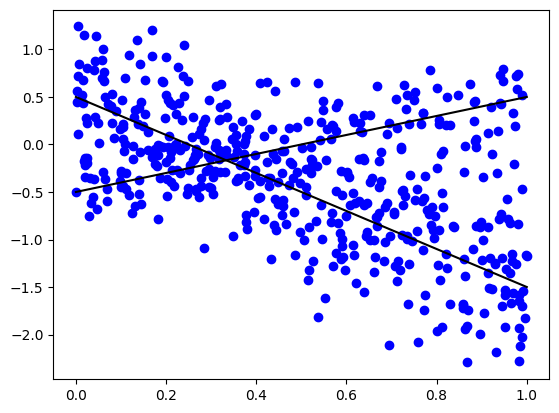

In [10]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
n = 500 #sample size
K = 2 #number of lines
e = np.array([0.7,0.3]) #mixing weights
w = np.array([-2,1]) #slopes of lines
b = np.array([0.5,-0.5]) #offsets of lines
v = np.array([0.2,0.1]) #variances
x = np.zeros([n])
y = np.zeros([n])
for i in range(0,n):
    x[i] = np.random.rand(1)
    if np.random.rand(1) < e[0]:
        y[i] = w[0]*x[i] + b[0] + np.random.randn(1)*np.sqrt(v[0])
    else:
        y[i] = w[1]*x[i] + b[1] + np.random.randn(1)*np.sqrt(v[1])

plt.plot(x,y,'bo')

t = np.linspace(0, 1, num=100)
plt.plot(t,w[0]*t+b[0],'k')
plt.plot(t,w[1]*t+b[1],'k')
plt.show()

# EM Solver

In [3]:
class EMSolver:
    def __init__(self, initial_weights, initial_epsilons, initial_variances) -> None:
        self.weights = initial_weights
        self.epsilons = initial_epsilons
        self.variances = initial_variances
        self.log_likelihoods = [-np.inf]
    
    def normal_likelihood(self, x, y, weights, variances):
        return stats.norm.pdf(y, loc=x @ weights, scale=np.sqrt(variances))
    
    def log_likelihood(self, X, Y):
        K = len(self.variances)
        likelihoods = np.zeros((len(X), K))
        for k in range(K):
            likelihoods[:,k] = self.epsilons[k] * self.normal_likelihood(X, Y, self.weights[:,k], self.variances[k])
        likelihood = np.sum(np.log(np.sum(likelihoods, axis=1)))
        return likelihood

    def e_step(self, X, Y):
        # calculate the responsibilities
        n = len(X)
        K = len(self.variances)
        responsibilities = np.zeros((n, K))
        for k in range(K):
            responsibilities[:, k] = self.epsilons[k] * self.normal_likelihood(X, Y, self.weights[:,k], self.variances[k])
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
        return responsibilities

    def m_step(self, X, Y, responsibilities):
        # update the parameters
        n = len(X)
        K = len(self.variances)
        for k in range(K):
            gamma = np.diag(responsibilities[:, k])
            self.weights[:,k] = np.linalg.inv(X.T@ gamma @ X) @ X.T @ gamma @ Y
            diff = Y - X @ self.weights[:,k]
            self.variances[k] = ((diff).T @ gamma @ (diff)) / np.sum(responsibilities[:, k])
            self.epsilons[k] = np.sum(responsibilities[:, k])/ n


    def fit(self, X, Y, max_iter=1000, tol=1e-4):
        for i in range(max_iter):
            responsibilities = self.e_step(X, Y)
            self.m_step(X, Y, responsibilities)
            self.log_likelihoods.append(self.log_likelihood(X, Y))
            if np.abs(self.log_likelihoods[-2] - self.log_likelihoods[-1]) < tol:
                break

        return self.weights, self.variances, self.epsilons

## Solving For Parameters

[[ 0.89003747 -1.98277241]
 [-0.41030643  0.52114894]]
[0.0611611  0.22921584]
[0.27979878 0.72020122]


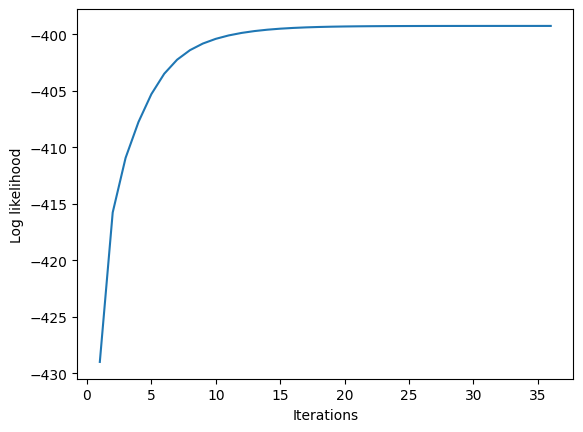

In [11]:
w_0 = np.array([
    [1, -1],
    [.01, 0]
])

#w_0 = np.array([w, b])

e_0 = np.array([0.5, 0.5])

v_0 = np.std(y) ** 2 * np.ones(2)


X = np.c_[x, np.ones(n)]
Y = y

solver = EMSolver(w_0, e_0, v_0)
weights, variances, epsilons = solver.fit(X, Y, max_iter=2000, tol=1e-4)

print(weights)
print(variances)
print(epsilons)

plt.plot(range(len(solver.log_likelihoods)), solver.log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')
plt.show()

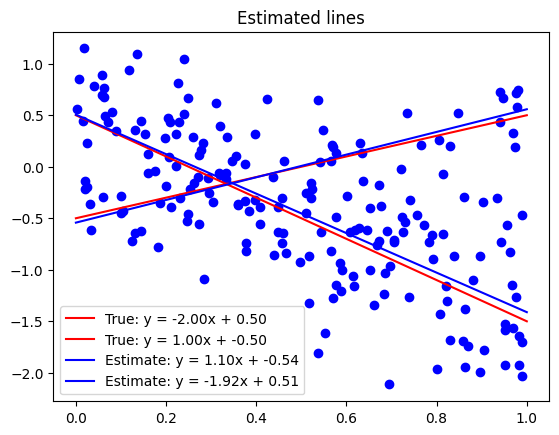

In [8]:
plt.plot(x,y,'bo')

t = np.linspace(0, 1, num=100)
plt.plot(t,w[0]*t+b[0],'r-', label=f'True: y = {w[0]:.2f}x + {b[0]:.2f}')
plt.plot(t,w[1]*t+b[1],'r-', label=f'True: y = {w[1]:.2f}x + {b[1]:.2f}')
plt.plot(t,weights[0,0]*t+weights[1,0],'b', label=f'Estimate: y = {weights[0,0]:.2f}x + {weights[1,0]:.2f}')
plt.plot(t,weights[0,1]*t+weights[1,1],'b', label=f'Estimate: y = {weights[0,1]:.2f}x + {weights[1,1]:.2f}')
plt.title('Estimated lines')
plt.legend()
plt.show()